In [1]:
l1ascan = pd.read_hdf('/home/klay6683/to_keep/l1a_dark_scan.h5', 'df')

In [2]:
l1ascan = meta.clean_up_dark_scan(l1ascan)

In [3]:
l1ascan.columns

Index(['ANC_SVN_REVISION', 'BIN_PATTERN_INDEX', 'BIN_TBL', 'CADENCE',
       'CASE_TEMP', 'CHANNEL', 'CODE_SVN_REVISION', 'COLLECTION_ID',
       'DET_TEMP', 'DUTY_CYCLE', 'FILENAME', 'FOV_DEG', 'INT_TIME',
       'LYA_CENTROID', 'MCP_VOLT', 'MIRROR_DEG', 'MIRROR_DN', 'MIR_DEG',
       'MISSION_PHASE', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NAXIS3', 'N_FILL',
       'OBS_ID', 'ORBIT_NUMBER', 'PROCESS', 'PRODUCT_ID', 'SOLAR_LONGITUDE',
       'TARGET_NAME', 'TIME_OF_INT', 'mean', 'median', 'std', 'BINNING_SET'],
      dtype='object')

In [4]:
l1ascan.NAXIS3.value_counts(dropna=False)

 21     29757
 2       8718
NaN      7279
 226     2034
 104     1040
 88       880
 60       600
 97       388
 112      336
 49       196
 39        78
Name: NAXIS3, dtype: int64

In [15]:
def process_fname(fname):
    import pandas as pd
    l1a = io.L1AReader(fname)
    d = dict(fname=l1a.fname)
    if l1a.n_dims == 2:
        d['selfsub_mean'] = np.NAN
        d['selfsub_std'] = np.NAN
        return d
    elif l1a.img_header['NAXIS3'] == 2:
        ioffset = 0
        d['danger'] = '1vs2'
    else:
        ioffset = 1
    sub = l1a.primary_img_dn_s[0+ioffset] - l1a.primary_img_dn_s[1+ioffset]
    d['selfsub_mean'] = sub.mean()
    d['selfsub_std'] = sub.std()
    return d

In [16]:
process_fname(l1ascan.PRODUCT_ID.iloc[10000])

{'fname': '/maven_iuvs/production/products/level1a/mvn_iuv_l1a_periapse-orbit01551-muvdark_20150717T080731_v02_r01.fits.gz',
 'selfsub_mean': 0.030059893522626439,
 'selfsub_std': 0.10931654259397347}

In [17]:
from IPython.parallel import Client
c = Client()

In [18]:
dview = c.direct_view()
lview = c.load_balanced_view()

In [32]:
doing = l1ascan.PRODUCT_ID.unique()
results = lview.map_async(process_fname, doing)

In [33]:
from iuvs.multitools import nb_progress_display

In [34]:
nb_progress_display(results, doing)

In [35]:
resdf = pd.DataFrame(results.result)
resdf.head()

,danger,fname,selfsub_mean,selfsub_std
0,1vs2,/maven_iuvs/production/products/level1a/mvn_iu...,0.056936,0.242106
1,NaN,/maven_iuvs/production/products/level1a/mvn_iu...,-0.005026,0.049457
2,1vs2,/maven_iuvs/production/products/level1a/mvn_iu...,-0.001799,0.027644
3,NaN,/maven_iuvs/production/products/level1a/mvn_iu...,NaN,NaN
4,NaN,/maven_iuvs/production/products/level1a/mvn_iu...,NaN,NaN


In [36]:
resdf.to_hdf("/home/klay6683/to_keep/dark_minus_dark.h5", "df")

your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['danger', 'fname']]

  warnings.warn(ws, PerformanceWarning)



In [44]:
from pathlib import Path
def complete_product_id(pid):
    fname = io.productionlevel1apath / Path(pid)
    if fname.suffix == '.fits' or fname.suffix == '':
        fname = fname.with_suffix('.fits.gz')
    return str(fname)

In [45]:
l1ascan['fname'] = l1ascan.PRODUCT_ID.map(complete_product_id)

In [47]:
merged = l1ascan.merge(resdf, on='fname')

In [50]:
merged.COLLECTION_ID.value_counts()

limb           19085
disk           18143
corona          5646
cruise          4362
transition      3422
occultation      434
calibration      214
Name: COLLECTION_ID, dtype: int64

In [82]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')

In [61]:
%matplotlib nbagg

In [66]:
no_danger = merged[merged.danger.isnull()]

<IPython.core.display.Javascript object>


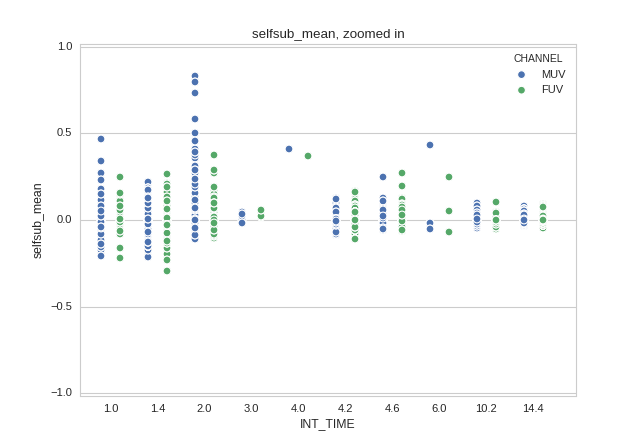

In [85]:
plt.figure()
ax = sns.stripplot(x='INT_TIME', y='selfsub_mean', hue='CHANNEL', 
              data=merged.sort_values(by='INT_TIME'))
ax.set_title('selfsub_mean, zoomed in')

<IPython.core.display.Javascript object>


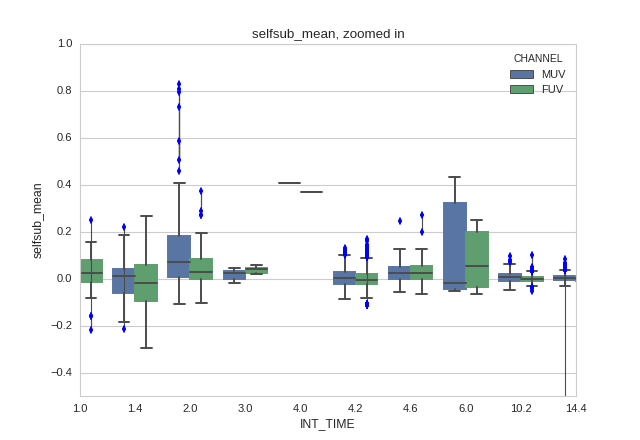

(1.0, 10)

In [118]:
plt.figure()
ax = sns.boxplot(x='INT_TIME', y='selfsub_mean', hue='CHANNEL', 
              data=merged.sort_values(by='INT_TIME'))
ax.set_title('selfsub_mean, zoomed in')
ax.set_ylim(-0.5, 1)
ax.set_xlim(1.0, 10)

In [99]:
merged['NAXIS3'] = merged.NAXIS3.fillna(1)

<IPython.core.display.Javascript object>


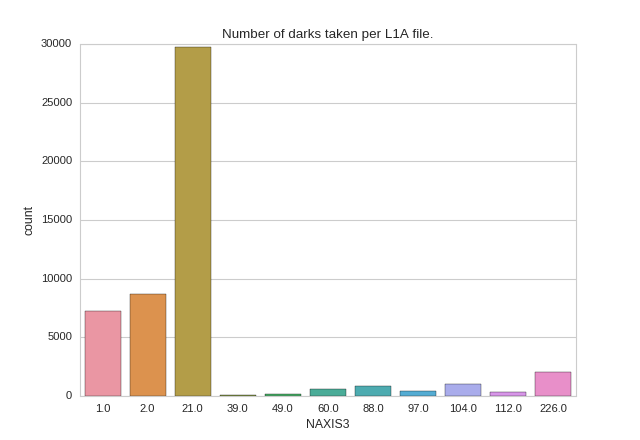

In [101]:
plt.figure()
ax = sns.countplot(x='NAXIS3', data=merged.sort_values(by='NAXIS3'))
ax.set_title('Number of darks taken per L1A file.')

<IPython.core.display.Javascript object>


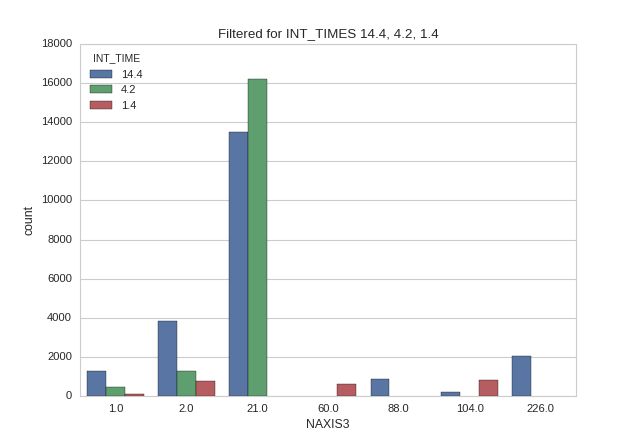

In [103]:
plt.figure()
ax = sns.countplot(x='NAXIS3', hue='INT_TIME', 
                   data=merged[merged.INT_TIME.isin([14.4, 4.2, 1.4])].sort_values(by='NAXIS3'))
ax.set_title('Filtered for INT_TIMES 14.4, 4.2, 1.4')

In [106]:
with_danger = merged[merged.danger=='1vs2']

<IPython.core.display.Javascript object>


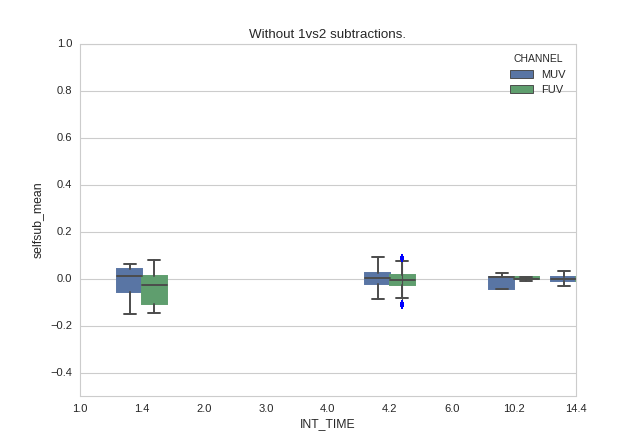

(1, 9)

In [122]:
plt.figure()
ax = sns.boxplot(x='INT_TIME', y='selfsub_mean', hue='CHANNEL', 
              data=no_danger.sort_values(by='INT_TIME'))
ax.set_title('Without 1vs2 subtractions.')
ax.set_ylim(-0.5, 1)
ax.set_xlim(1,9)

In [123]:
sns.boxplot?

<IPython.core.display.Javascript object>


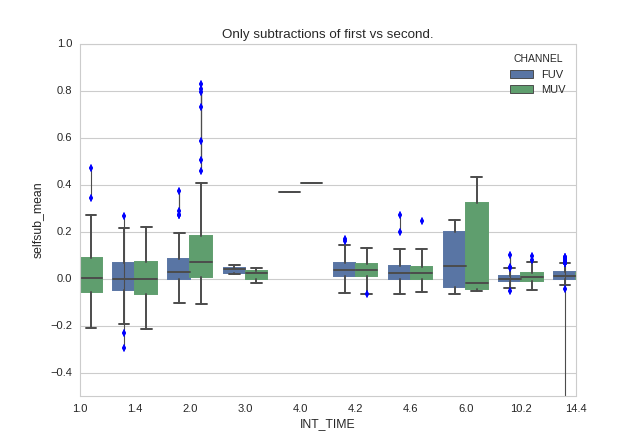

(0, 9)

In [120]:
plt.figure()
ax = sns.boxplot(x='INT_TIME', y='selfsub_mean', hue='CHANNEL', 
              data=with_danger.sort_values(by='INT_TIME'))
ax.set_title("Only subtractions of first vs second.")
ax.set_ylim(-0.5, 1)
ax.set_xlim(0, 9)

In [57]:
to_plot = merged[merged.COLLECTION_ID.isin(['limb','disk','corona','occulation'])]

In [58]:
to_plot.INT_TIME.value_counts()

14.4    21710
4.2     17984
1.4      2300
4.6       484
29.4      336
1.0        56
16.0        4
Name: INT_TIME, dtype: int64